A notebook to create the submission(s).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot, \
    SubstitutionOneHot, DNase, Classifier, Regression, StackedRegressionClassifier

## Load data

Read the training data with added conservation information.

In [2]:
training = pd.read_csv('data/cagi5_df.csv')
training.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


Read the submission template

In [3]:
submission = pd.read_csv(
    'data/submission-with-cons.tsv',
    sep='\t',
    na_values='*')
submission.sample(6)

,Chrom,Pos,Ref,Alt,Promoter_Enhancer,Direction,P_Direction,Confidence,SE,Comments,phastCon,phyloP,GerpN,GerpRS
12746,22,19711084,C,T,GP1BB,NaN,NaN,NaN,NaN,NaN,0.022,-0.317,3.95,0.641
12062,20,42984419,A,T,HNF4A,NaN,NaN,NaN,NaN,NaN,0.728,-0.153,4.98,-6.380
7589,8,128413098,G,C,MYC,NaN,NaN,NaN,NaN,NaN,0.714,0.651,5.22,4.280
1590,1,155271279,A,C,PKLR,NaN,NaN,NaN,NaN,NaN,0.319,0.375,4.74,1.000
11111,19,11200104,T,G,LDLR,NaN,NaN,NaN,NaN,NaN,0.005,0.457,4.87,0.468
12969,X,138612622,G,C,F9,NaN,NaN,NaN,NaN,NaN,0.001,-0.244,3.43,-5.100


Identify all the submission regions to check they match those in the training data.

In [4]:
sub_regions = submission['Promoter_Enhancer'].unique()
sub_regions.sort()
print(sub_regions)
train_regions = training['regulatory_element'].str.slice(start=8).unique()
train_regions.sort()
print(train_regions)

['F9' 'GP1BB' 'HBB' 'HBG1' 'HNF4A' 'IRF4' 'IRF6' 'LDLR' 'MSMB' 'MYC'
 'PKLR' 'SORT1' 'TERT-GBM' 'TERT-HEK293T' 'ZFAND3']
['F9' 'GP1BB' 'HBB' 'HBG1' 'HNF4A' 'IRF4' 'IRF6' 'LDLR' 'MSMB'
 'MYCrs6983267' 'PKLR' 'SORT1' 'TERT-GBM' 'TERT-HEK293T' 'ZFAND3']


TODO: Make sure that MYC region names match between training and submission data frames.

### Use tuned hyperparameters

These are taken from a kaggle kernel notebook

In [5]:
tuned_params={
    'max_depth': 2, #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': 0.6, #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': 0.5, #[0.5,0.6,0.7,0.8],
    'n_estimators': 1000, #[1000,2000,3000]
    'reg_alpha': 0.03 #[0.01, 0.02, 0.03, 0.04]
}

These are tuned by Bayesian optimisation (in another notebook)

In [6]:
tuned_params = {
    'colsample_bytree': 0.7524052235178577,
    'learning_rate': 0.39783003619093765,
    'max_depth': 7,
    'min_child_weight': 4.0467095559059505,
    'reg_alpha': 0.030682622499703896,
    'reg_lambda': 0.40505823486422077,
    'subsample': 1.0
}

### Choose features

In [7]:
def make_features(test):
    if test:
        ds500_dq = DeepSeaSNP(filename_fmt='ds500-dq-embed64-500-d20-3-5-11-test_{}_preds_v1.npy')
    else:
        ds500_dq = DeepSeaSNP(filename_fmt='ds500-dq-embed64-500-d20-3-5-11_{}_preds_v1.npy')
    dnase = DNase(test=test)
    conservation = Conservation()
    # subst = SubstitutionOneHot(test=test)
    # enhancer1hot = EnhancerOneHot(test=test)
    # snpcontext2 = SNPContext(context_size=2, test=test)
    # snpcontext4 = SNPContext(context_size=4, test=test)
    # stacked = Stacked('deep-dnase-cons', test=test)
    return MultiFeatures([ds500_dq, dnase, conservation])
train_features = make_features(False)
test_features = make_features(True)

## Fit model

In [30]:
# import models, importlib
# importlib.reload(models)
# from models import Regression, Classifier, StackedRegressionClassifier
regression = Regression(train_features)
classifier = Classifier(train_features)
stacked = StackedRegressionClassifier(regression, classifier)
X_train = stacked.get_features(training)
y_train = stacked.get_response(training)
stacked.fit(X_train, y_train)

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Make predictions

In [31]:
X_test = test_features.get_features(submission)
predictions = stacked.predict(X_test, submission.index)
predictions.sample(6)

,NegativeProb,PositiveProb,PredClass,PredConfidence,PredValue,UncalledProb
3378,0.253668,0.340686,0,0.080030,-0.002268,0.405646
4182,0.155030,0.354109,0,0.027273,-0.007134,0.490860
723,0.304105,0.401524,1,0.259756,0.029681,0.294371
7193,0.321593,0.263593,0,0.095455,-0.068712,0.414814
2523,0.253256,0.664458,1,0.067500,0.097256,0.082286
10530,0.346193,0.247672,0,0.069239,-0.146601,0.406135


Call which variants are present from the regression predictions

In [32]:
# import models, importlib
# importlib.reload(models)
# from models import call_variants_from_regression
predictions = stacked.make_submission(predictions)
predictions.sample(6)

,NegativeProb,PositiveProb,PredClass,PredConfidence,PredValue,UncalledProb,Direction,P_Direction,Confidence,SE
4722,0.249136,0.378511,1,0.059733,-0.093235,0.372353,1,0.378511,0.059733,0.1
13437,0.225809,0.320781,0,0.052757,0.057173,0.453410,0,0.453410,0.052757,0.1
12871,0.430168,0.296137,-1,0.050824,-0.051259,0.273694,-1,0.430168,0.050824,0.1
4331,0.291308,0.304294,0,0.058591,-0.048523,0.404398,0,0.404398,0.058591,0.1
4364,0.269696,0.333023,0,0.056732,0.015346,0.397281,0,0.397281,0.056732,0.1
1865,0.245768,0.454292,1,0.104047,-0.027168,0.299940,1,0.454292,0.104047,0.1


Plot the predicted values against the probability that they are correct coloured by called direction.

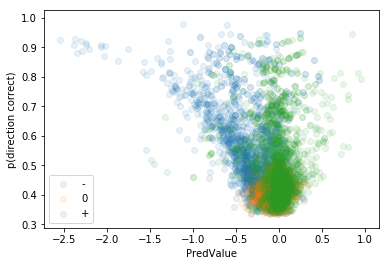

In [35]:
fig, ax = plt.subplots()
alpha = .1
neg = -1 == predictions['Direction']
zero = 0 == predictions['Direction']
pos =  1 == predictions['Direction']
ax.scatter(predictions.loc[neg, 'PredValue'], predictions.loc[neg, 'P_Direction'], label='-', alpha=alpha)
ax.scatter(predictions.loc[zero, 'PredValue'], predictions.loc[zero, 'P_Direction'], label='0', alpha=alpha)
ax.scatter(predictions.loc[pos, 'PredValue'], predictions.loc[pos, 'P_Direction'], label='+', alpha=alpha)
ax.legend()
ax.set_xlabel('PredValue')
ax.set_ylabel('p(direction correct)')
None

### Save predictions

In [34]:
# import utils, importlib
# importlib.reload(utils)
for col in ['Direction', 'P_Direction', 'Confidence', 'SE']:
    submission[col] = predictions[col]
submission['Comments'] = '*'
utils.write_submission(submission, 'data/submission.tsv')

Writing submission to: data/submission.tsv
